In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

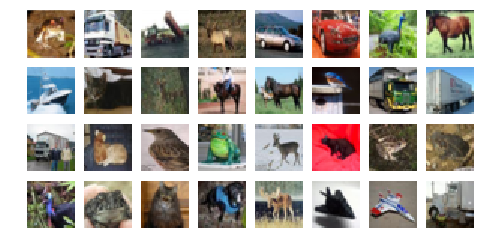

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

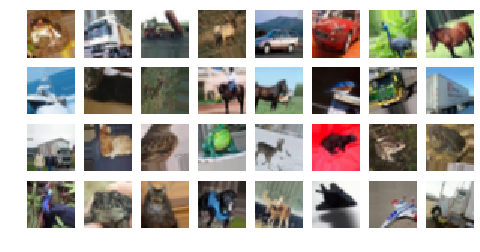

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

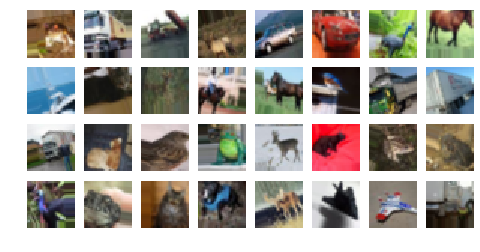

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [8]:
# ref : Day098
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os

In [9]:
def calc_steps_per_epoch(data_size, batch_size):
    steps = data_size // batch_size
    if data_size % batch_size != 0:
        steps += 1
    return steps

In [10]:
# ref: Day097
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Conv2D(32, (3, 3)))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Conv2D(64, (3, 3)))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [11]:
# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [12]:
# batch 的大小，如果出現 OOM error，請降低這個值
#batch_size = 32 
batch_size = 1024 
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

In [13]:
# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [14]:
# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## 將資料攤平成一維資料
#x_train = x_train.reshape(x_train.shape[0], 3072) 
#x_test = x_test.reshape(x_test.shape[0], 3072)

print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(50000, 32, 32, 3) train samples
(10000, 32, 32, 3) test samples


ref: [Image Preprocessing](https://keras.io/preprocessing/image/)

In [15]:
test_cases = {
    # case_name: params
    'raw_data': dict(
     ),
    'rotation': dict(
        rotation_range=90,
     ),
    'shift': dict(
        width_shift_range=0.2,
        height_shift_range=0.2,
     ),
    'zoom': dict(
        zoom_range=0.5,        
     ),
    'horizontal_flip': dict(
        horizontal_flip=True,        
     ),
    'vertical_flip': dict(
        vertical_flip=True,        
     ),
}

In [16]:
model = build_model()
base_model_init_weights = model.get_weights()
    
results = {}

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
import keras
from keras.preprocessing.image import ImageDataGenerator

for i, (case_name, params) in enumerate(test_cases.items()):
    print()
    print(f"{'='*20} [{case_name:30s}] {'='*20}")

    #key = to_key(params)
    #if key in results:
    #    continue
          
    keras.backend.clear_session() # 把舊的 Graph 清掉

    # ref: https://keras.io/preprocessing/image/  
    datagen = ImageDataGenerator(**params)
    datagen.fit(x_train)

    model = build_model()
    model.set_weights(base_model_init_weights)

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  #optimizer=Adam(lr=10e-3),
                  metrics=['accuracy'])

    history = model.fit_generator(
                    datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=False),
                    steps_per_epoch=calc_steps_per_epoch(len(x_train), batch_size), 
                    epochs=epochs,
                    verbose=1,
                    shuffle=False,
                    validation_data=(x_test, y_test))

    score = model.evaluate(x_test, y_test, verbose=0)

    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    results[case_name]  = score



==================== [raw_data                      ] ====================
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________


Epoch 1/10
49/49 [==============================] - 91s 2s/step - loss: 1.7000 - acc: 0.4172 - val_loss: 2.2238 - val_acc: 0.3223
Epoch 2/10
49/49 [==============================] - 87s 2s/step - loss: 1.3304 - acc: 0.5237 - val_loss: 1.8541 - val_acc: 0.4185
Epoch 3/10
49/49 [==============================] - 85s 2s/step - loss: 1.2014 - acc: 0.5697 - val_loss: 1.2894 - val_acc: 0.5563
Epoch 4/10
49/49 [==============================] - 85s 2s/step - loss: 1.1215 - acc: 0.5990 - val_loss: 1.2704 - val_acc: 0.5546
Epoch 5/10
49/49 [==============================] - 85s 2s/step - loss: 1.0633 - acc: 0.6225 - val_loss: 1.3806 - val_acc: 0.5335
Epoch 6/10
49/49 [==============================] - 87s 2s/step - loss: 1.0111 - acc: 0.6438 - val_loss: 1.1097 - val_acc: 0.6162
Epoch 7/10
49/49 [==============================] - 85s 2s/step - loss: 0.9678 - acc: 0.6573 - val_loss: 1.4143 - val_acc: 0.5408
Epoch 8/10
49/49 [==============================] - 86s 2s/step - loss: 0.9314 - acc: 0.67

49/49 [==============================] - 83s 2s/step - loss: 0.4337 - acc: 0.8611 - val_loss: 0.9786 - val_acc: 0.6867
Epoch 9/10
49/49 [==============================] - 83s 2s/step - loss: 0.3829 - acc: 0.8789 - val_loss: 1.0882 - val_acc: 0.6557
Epoch 10/10
49/49 [==============================] - 83s 2s/step - loss: 0.3357 - acc: 0.8952 - val_loss: 1.0171 - val_acc: 0.6846
Test loss: 1.0171327776908874
Test accuracy: 0.6846

==================== [vertical_flip                 ] ====================
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
______________________________

In [19]:
ref_score = results['raw_data']
ref_acc = ref_score[1]
for case_name, score in results.items():
    test_acc = score[1]
    print(f"{case_name:30s}: accuracy = {test_acc:.7f} ({(test_acc-ref_acc):+.7f})")

raw_data                      : accuracy = 0.6434000 (+0.0000000)
rotation                      : accuracy = 0.6034000 (-0.0400000)
shift                         : accuracy = 0.5994000 (-0.0440000)
zoom                          : accuracy = 0.6710000 (+0.0276000)
horizontal_flip               : accuracy = 0.6846000 (+0.0412000)
vertical_flip                 : accuracy = 0.5740000 (-0.0694000)
